In [9]:
import os
import cv2
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from collections import defaultdict
from ultralytics import YOLO
from scipy import stats
from tqdm import tqdm
from PIL import Image

# Preprocesamiento

In [10]:
# Metadata para ordenar el entrenamiento
metadata_path = 'datasets\Labeled Stomatal Images.csv'
metadata = pd.read_csv(metadata_path)

In [11]:
# Mediciones 1 plant-out
def onePlantOut(plant_name):
  main_folder = 'datasets'

  train_images_folder = os.path.join(main_folder, 'train/images')
  train_labels_folder = os.path.join(main_folder, 'train/labels')
  val_images_folder = os.path.join(main_folder, 'val/images')
  val_labels_folder = os.path.join(main_folder, 'val/labels')

  folders = [train_images_folder, train_labels_folder, val_images_folder, val_labels_folder]

  # Sino existen los directorios
  for folder in folders:
      if not os.path.exists(folder):
          os.makedirs(folder)

  # Seleccionar la planta a medir su rendimiento
  plant = plant_name
  trainFiles = metadata[metadata['Species'] != plant]['FileName'].tolist()
  valFiles = metadata[metadata['Species'] == plant]['FileName'].tolist()

  for folder in folders:
    for file in os.listdir(folder):
      if file.split(".")[0] in trainFiles:
        if file.endswith(".jpg"):
          shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'train/images', file))
        elif file.endswith(".txt"):
          shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'train/labels', file))

  for folder in folders:
    for file in os.listdir(folder):
      if file.split(".")[0] in valFiles:
        if file.endswith(".jpg"):
          shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'val/images', file))
        elif file.endswith(".txt"):
          shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'val/labels', file))

def holdOut(random_seed = 42, test_size = 0.2):
    random.seed(random_seed)
    main_folder = 'datasets'

    train_images_folder = os.path.join(main_folder, 'train/images')
    train_labels_folder = os.path.join(main_folder, 'train/labels')
    val_images_folder = os.path.join(main_folder, 'val/images')
    val_labels_folder = os.path.join(main_folder, 'val/labels')

    folders = [train_images_folder, train_labels_folder, val_images_folder, val_labels_folder]

  # Sino existen los directorios
    for folder in folders:
        if not os.path.exists(folder):
            os.makedirs(folder)

    # Obtener todos los archivos de la columna 'FileName'
    all_files = metadata['FileName'].tolist()

    # Mezclar aleatoriamente los archivos
    random.shuffle(all_files,)

    split_idx = int((1-test_size) * len(all_files))
    trainFiles = all_files[:split_idx]
    valFiles = all_files[split_idx:]

    for folder in folders:
        for file in os.listdir(folder):
            if file.split(".")[0] in trainFiles:
                if file.endswith(".jpg"):
                    shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'train/images', file))
                elif file.endswith(".txt"):
                    shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'train/labels', file))
    
    for folder in folders:
        for file in os.listdir(folder):
            if file.split(".")[0] in valFiles:
                if file.endswith(".jpg"):
                    shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'val/images', file))
                elif file.endswith(".txt"):
                    shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'val/labels', file))
                    
def plot_detections(results):
    img_rgb = cv2.cvtColor(results.orig_img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img_rgb)
    for box, score in zip(results.boxes.xyxy, results.boxes.conf):
        x1, y1, x2, y2 = box
        # Coordenadas deben ser ints
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        width, height = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Mostrar el score como etiqueta en la esquina superior izquierda de la caja
        label = f"{score:.2f}"  # Formatear el score a 2 decimales
        ax.text(x1, y1, label, color='white', fontsize=5, verticalalignment='top', bbox={'color': 'r', 'pad': 0})
        
    plt.show()

def show_image(image_path, txt_path):
    img = cv2.imread(image_path)
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    # Leer y mostrar el contenido del archivo .txt
    with open(txt_path, 'r') as file:
        annotations = file.readlines()

    for annotation in annotations:
        class_id, x_center, y_center, width, height = map(float, annotation.split())
        x = (x_center - width / 2) * img.shape[1]
        y = (y_center - height / 2) * img.shape[0]
        w = width * img.shape[1]
        h = height * img.shape[0]
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

# Test

In [12]:
# Elegir el tipo de preprocesamiento
holdOut(random_seed = 42, test_size = 0.2)
# onePlantOut("Nuttall oak")

model8 = YOLO('Modelos\yolov8\HoldOutSimpleYolov8n.pt')
model8Adjust = YOLO('Modelos\yolov8\HoldOutAdjustYolov8n.pt')
model10 = YOLO('Modelos\yolov10\HoldOutSimpleYolov10n.pt')
model10Adjust = YOLO('Modelos\yolov10\HoldOutAdjustYolov10n.pt')

ReTrainModel10 = YOLO("Modelos\yolov10\HoldOutSimpleYolov10nRETRAIN.pt")  

## Test visual


image 1/1 c:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\train\images\STMHD0002.jpg: 480x640 80 stoma1s, 78 stoma2s, 115.2ms
Speed: 5.0ms preprocess, 115.2ms inference, 25.6ms postprocess per image at shape (1, 3, 480, 640)


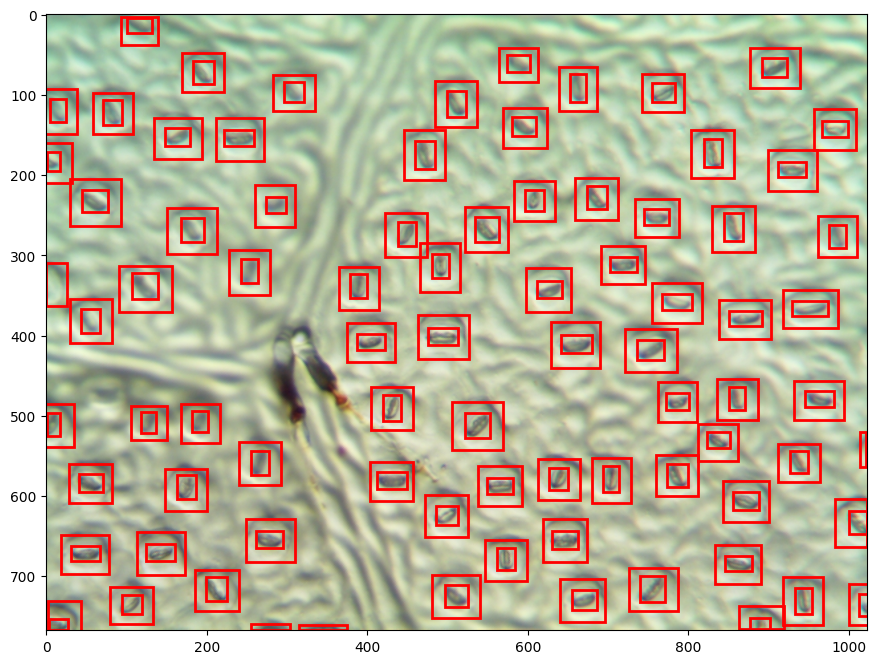

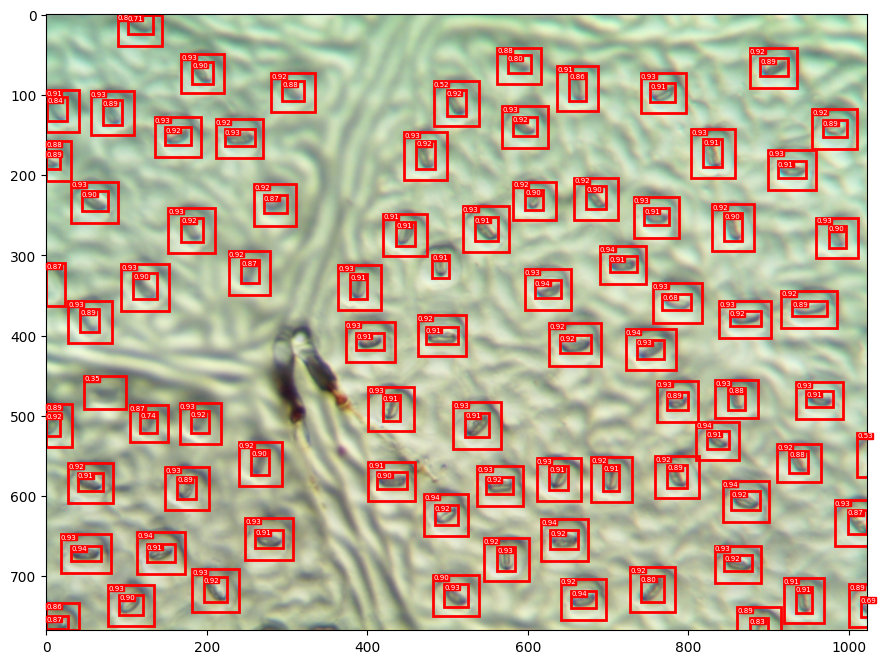

In [13]:
PATH_images = "datasets/train/images"
PATH_labels = "datasets/train/labels"
plant_type = '/STMHD'
number = "0002"
image_path = f"{PATH_images}{plant_type}{number}.jpg"
txt_path = f"{PATH_labels}{plant_type}{number}.txt"

results = model10.predict(image_path)[0]

show_image(image_path, txt_path)
plot_detections(results)

## Test métricas


In [14]:
# results8 = model8.val(data='YOLO8INFO.yaml', save_json=False)
# results8Adjust = model8Adjust.val(data='YOLO8INFO.yaml', save_json=False)
# results10 = model10.val(data='YOLO8INFO.yaml', save_json=False)
# results10Adjust = model10Adjust.val(data='YOLO8INFO.yaml', save_json=False)

# Contador

In [ ]:
def count_bounding_boxes(model, image_path, confidence_threshold):
    results = model.predict(image_path, verbose=False)
    bbox_counts = defaultdict(int)

    for result in results:
        for box in result.boxes: 
            if box.conf >= confidence_threshold: 
                class_id = int(box.cls) 
                bbox_counts[class_id] += 1

    return bbox_counts

def load_labels(label_path):
    labels = defaultdict(list)
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            class_id = int(parts[0])
            bbox = list(map(float, parts[1:]))
            labels[class_id].append(bbox)
    return labels

def calculate_differences(pred_counts, real_counts):
    differences = {} 

    all_classes = set(pred_counts.keys()).union(set(real_counts.keys()))

    for class_id in all_classes:
        real_count = real_counts.get(class_id, 0)
        pred_count = pred_counts.get(class_id, 0)

        difference = pred_count - real_count
        differences[class_id] = difference

    return differences

# Confidence Threshold de yolo es 0.25 por defecto
def compare_predictions_with_labels(model, image_path, label_path, confidence_threshold = 0.25): 

    pred_counts = count_bounding_boxes(model, image_path, confidence_threshold)

    real_labels = load_labels(label_path)

    real_counts = {class_id: len(bboxes) for class_id, bboxes in real_labels.items()}

    differences_by_class = calculate_differences(pred_counts, real_counts)

    return differences_by_class


In [17]:
a = count_bounding_boxes(model8,image_path,confidence_threshold=0.25)

In [ ]:
a[0]

defaultdict(int, {0: 82, 1: 79})

In [ ]:
image_dir = 'datasets/val/images'
label_dir = 'datasets/val/labels'

images = [img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.png'))]

differences8 = []
differences8Adjust = []
differences10 = []
differences10Adjust = []

for image_name in tqdm(images):
    image_path = os.path.join(image_dir, image_name)
    label_path = os.path.join(label_dir, image_name.replace('.jpg', '.txt').replace('.png', '.txt'))
    differences8_by_class = compare_predictions_with_labels(model8, image_path, label_path)
    differences8.append(differences8_by_class)
    differences8Adjust_by_class = compare_predictions_with_labels(model8Adjust, image_path, label_path)
    differences8Adjust.append(differences8Adjust_by_class)
    differences10_by_class = compare_predictions_with_labels(model10, image_path, label_path)
    differences10.append(differences10_by_class)
    differences10Adjust_by_class = compare_predictions_with_labels(model10Adjust, image_path, label_path)
    differences10Adjust.append(differences10Adjust_by_class)


100%|██████████| 2143/2143 [07:07<00:00,  5.01it/s]


In [33]:
def calculate_statistics(differences):
    media = np.mean(differences)
    mediana = np.median(differences)
    desviacion_estandar = np.std(differences)
    varianza = np.var(differences)
    rango = np.ptp(differences)
    minimo = np.min(differences)
    maximo = np.max(differences)
    sesgo = stats.skew(differences)
    curtosis = stats.kurtosis(differences)
    
    return {
        "media": media,
        "mediana": mediana,
        "desviacion_estandar": desviacion_estandar,
        "varianza": varianza,
        "rango": rango,
        "minimo": minimo,
        "maximo": maximo,
        "sesgo": sesgo,
        "curtosis": curtosis
    }

def flatten_differences_by_class(differences):
    class_differences = defaultdict(list)
    for diff in differences:
        for class_id, value in diff.items():
            class_differences[class_id].append(value)
    return class_differences

def calculate_and_print_stats_by_class(flat_differences):
    for class_id, diffs in flat_differences.items():
        stats_by_class = calculate_statistics(diffs)
        print(f"Clase {class_id}:")
        print(stats_by_class)
        print()


In [34]:
flat_differences8 = flatten_differences_by_class(differences8)
flat_differences8Adjust = flatten_differences_by_class(differences8Adjust)
flat_differences10 = flatten_differences_by_class(differences10)
flat_differences10Adjust = flatten_differences_by_class(differences10Adjust)

print("Métricas estadísticas por clase para model8:")
calculate_and_print_stats_by_class(flat_differences8)

print("Métricas estadísticas por clase para model8Adjust:")
calculate_and_print_stats_by_class(flat_differences8Adjust)

print("Métricas estadísticas por clase para model10:")
calculate_and_print_stats_by_class(flat_differences10)

print("Métricas estadísticas por clase para model10Adjust:")
calculate_and_print_stats_by_class(flat_differences10Adjust)

Métricas estadísticas por clase para model8:
Clase 0:
{'media': 0.9295380307979468, 'mediana': 0.0, 'desviacion_estandar': 2.8153933444413473, 'varianza': 7.9264396839246345, 'rango': 43, 'minimo': -7, 'maximo': 36, 'sesgo': 3.7764537653466914, 'curtosis': 30.326678728388075}

Clase 1:
{'media': 1.698174006444683, 'mediana': 1.0, 'desviacion_estandar': 3.366318750342194, 'varianza': 11.33210192890543, 'rango': 37, 'minimo': -5, 'maximo': 32, 'sesgo': 2.5721472544961874, 'curtosis': 10.981376045668727}

Métricas estadísticas por clase para model8Adjust:
Clase 0:
{'media': 1.0718618758749416, 'mediana': 1.0, 'desviacion_estandar': 2.686352128941726, 'varianza': 7.216487760669743, 'rango': 41, 'minimo': -7, 'maximo': 34, 'sesgo': 3.2584814136647653, 'curtosis': 23.79499662415966}

Clase 1:
{'media': 1.5293484114162628, 'mediana': 1.0, 'desviacion_estandar': 3.2022685240880415, 'varianza': 10.254523700365004, 'rango': 39, 'minimo': -5, 'maximo': 34, 'sesgo': 2.8953081161416456, 'curtosis':

# Test Re-Entrenados

In [ ]:
results10Retrain = ReTrainModel10.val(data='YOLO8INFO.yaml', save_json=False)

Ultralytics YOLOv8.2.100  Python-3.10.9 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)


val: Scanning C:\Escritorio\Semestre 10\Stomatal-Density-with-Deep-Learning\datasets\val\labels.cache... 2143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2143/2143 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 134/134 [00:52<00:00,  2.55it/s]


                   all       2143     163185      0.963      0.959       0.99      0.809
                stoma1       2143      99280      0.972      0.958      0.991      0.829
                stoma2       1807      63905      0.955       0.96      0.989      0.789
Speed: 0.1ms preprocess, 3.6ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\detect\val4


100%|██████████| 2143/2143 [01:45<00:00, 20.37it/s]


In [36]:
image_dir = 'datasets/val/images'
label_dir = 'datasets/val/labels'

images = [img for img in os.listdir(image_dir) if img.endswith(('.jpg', '.png'))]

differences = []

for image_name in tqdm(images):
    image_path = os.path.join(image_dir, image_name)
    label_path = os.path.join(label_dir, image_name.replace('.jpg', '.txt').replace('.png', '.txt'))
    differences_by_class = compare_predictions_with_labels(ReTrainModel10, image_path, label_path)
    differences.append(differences_by_class)

100%|██████████| 2143/2143 [01:49<00:00, 19.52it/s]


In [37]:
flat_differences = flatten_differences_by_class(differences)

print("Métricas estadísticas por clase:")
calculate_and_print_stats_by_class(flat_differences)

Métricas estadísticas por clase:
Clase 0:
{'media': 0.8343443770415305, 'mediana': 0.0, 'desviacion_estandar': 2.4165196214096496, 'varianza': 5.839567080657837, 'rango': 35, 'minimo': -6, 'maximo': 29, 'sesgo': 2.8122240723170084, 'curtosis': 20.772402350353723}

Clase 1:
{'media': 1.373404255319149, 'mediana': 1.0, 'desviacion_estandar': 2.8687485421834666, 'varianza': 8.229718198279764, 'rango': 32, 'minimo': -12, 'maximo': 20, 'sesgo': 1.5464792121187552, 'curtosis': 5.635569406006885}

